## Imports & preparation

In [73]:
import numpy as np
import pandas as pd

# Import the Generator class
from bioverse.generator import Generator
from bioverse.survey import TransitSurvey
from bioverse.constants import CONST, DATA_DIR
# from bioverse import util

# Import pyplot (for making plots later) and adjust some of its settings
from matplotlib import pyplot as plt
# %matplotlib osx
%matplotlib inline

plt.rcParams['font.size'] = 20.

%load_ext autoreload
%autoreload 2

pd.options.display.max_rows = 200
pd.options.display.max_columns = 80

figdir = '~/repos/magmaocean/src/tex/figures/'
talkfigdir = '/Users/schlecker/talks/20221107_HabitableWorlds_Bioverse/figures/' 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## preparatory steps (to be done only once)

Read in Dorn & Lichtenberg 2021 Fig. 3b from plot line extractor

Text(0, 0.5, 'Radius deviation')

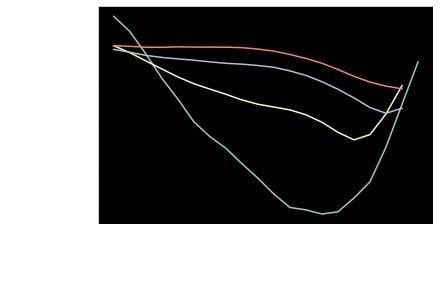

In [80]:
from scipy.interpolate import interp1d
from bioverse.constants import DATA_DIR

wrr_grid = np.geomspace(1e-4, 3e-1, num=20)
xy = {'wrr' : wrr_grid}

for i, (mp, mp_flt) in enumerate(zip(['0p3', '0p8', '2p4', '6p7'], [0.3, 0.8, 2.4, 6.7])):
    # read extracted csv file (from plot extraction tool)
    df = pd.read_csv(DATA_DIR + 'deltaR_DornLichtenberg21_Fig3b_extracted.csv', usecols=[2*i,2*i+1])
    f_xy = interp1d(df[mp + 'x'], df[mp + 'y'], fill_value='extrapolate')
    xy[mp_flt] = f_xy(wrr_grid)
    
    plt.plot(xy['wrr'], xy[mp_flt])
plt.xscale('log')
plt.xlabel('water mass fraction')
plt.ylabel('Radius deviation')

# pd.DataFrame(xy).to_csv(DATA_DIR + 'deltaR_DornLichtenberg21_Fig3b.csv', index=False)

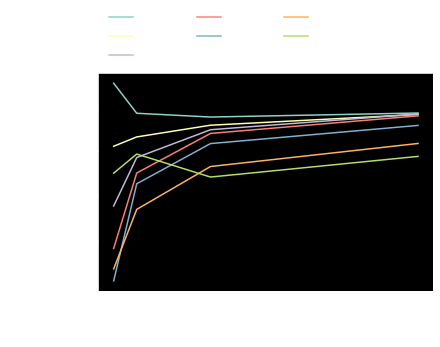

In [81]:
# sanity-check the interpolation
df = pd.read_csv(DATA_DIR + 'deltaR_DornLichtenberg21_Fig3b.csv', )

mass_grid = np.arange(0.3, 7., 0.1)

for wrr in wrr_grid[::3]:
    dr_wrr = df.iloc[(df['wrr'] - wrr).abs().argsort()[0], :][1:]
    f_dr = interp1d(dr_wrr.index.to_numpy(dtype=float), dr_wrr.values, fill_value='extrapolate')
    dr = f_dr(mass_grid)
    plt.plot(mass_grid, dr, label = '{:.0e}'.format(wrr))

# for i, mp_flt in enumerate([0.3, 0.8, 2.4, 6.7]):
    # f_xy = interp1d(df[mp + 'x'], df[mp + 'y'], fill_value='extrapolate')
    # xy[mp_flt] = f_xy(wrr_grid)
    # plt.plot(df['wrr'], df[str(mp_flt)])
    
# plt.xscale('log')

plt.xlabel('planet mass')
plt.ylabel('Radius deviation')
plt.legend(fontsize=12, loc='lower left', ncol=3, bbox_to_anchor=(0.0, 1.),
                              frameon=False, columnspacing=1.6)
 

# Sample generation

## Generate stars and planets, inject magma oceans

A fraction `f_magma` of planets are equipped with a global magma ocean, which reduce their radii. The probability of having a magma ocean is further dependent on the semimajor axis of the planet (as a proxy for irradiation by the host star).

For now, we model this dependence as a step function or an exponential decay in `a`.


Created a new Generator


Generator with 8 steps:
 0: Function 'read_stars_Gaia' with 11 keyword arguments.
 1: Function 'create_planets_bergsten' with 7 keyword arguments.
 2: Function 'assign_orbital_elements' with 2 keyword arguments.
 3: Function 'impact_parameter' with 1 keyword arguments.
 4: Function 'assign_mass' with 1 keyword arguments.
 5: Function 'effective_values' with no keyword arguments.
 6: Function 'magma_ocean' with 6 keyword arguments.
 7: Function 'compute_transit_params' with no keyword arguments.

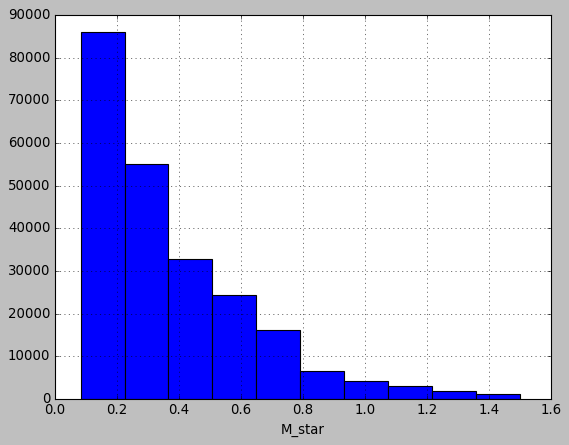

In [230]:
# Parameters of the analysis
# parameter_of_interest = 'rho'
parameter_of_interest = 'R'


# Parameters for star generation 
stars_args = {
# T_eff_max = 4000       # maximum stellar effective temperature in K to consider
'T_eff_split': 9700,     # Make sure there are some hotter stars as well (is this a bug that this is needed?)
'M_st_max' : 1.5,        # Maximum stellar mass to consider, in solar units.
# 'Mst_threshold' : 0.3,   # stellar mass threshold (i.e., 'what do we call "late"?')
# 'd_max' : 25,           # max. distance to stars in parsec
'd_max' : 110,           # max. distance to stars in parsec
'seed' : 42,              # seed for random number generators
'lum_evo' : False        # luminosities from luminosity tracks (Baraffe et al. 1998), based on random ages? [SLOW!]
} 

g_transit = Generator(label=None)
# g_transit.insert_step('create_stars_Gaia')
g_transit.insert_step('read_stars_Gaia')    # new version by KHU

# provide generator arguments chosen above
[g_transit.set_arg(key, val) for key, val in stars_args.items()]

# Insert a function to the generator that labels late M dwarfs, defining a stellar mass threshold Mst_threshold.
# g_transit.insert_step(label_lateM)

# the stellar sample alone can be extracted here:
stars = g_transit.generate() 
stars.to_pandas().M_st.hist()
plt.xlabel('M_star')
    
# ------------------------------------------------------
# Parameters for planet generation and magma ocean model
planets_args = {
'normalize_SpT': True, # Make sure occurrence rate is modulated with M_star
'optimistic' : True,   # If True, extrapolate the results of Mulders+2015 by assuming rocky planets are much more common around late-type M dwarfs. If False,
# 'optimistic' : False,   # If True, extrapolate the results of Mulders+2015 by assuming rocky planets are much more common around late-type M dwarfs. If False,
                       # assume that occurrence rates plateau with stellar mass for stars cooler than ~M3.
'transit_mode': False,  # Simulate only transiting planets
# 'transit_mode': True,  # Simulate only transiting planets
    
'mr_relation' : 'Zeng2016', # choice of mass-radius relationship
    
# 'funform' : 'step',    # functional form of magma ocean probability aafo sma, either "exp_decay" or "step"
# 'funform' : 'exp_decay',    # functional form of magma ocean probability aafo sma, either "exp_decay" or "step"
# 'lambda_a' : 2.,       # "decay parameter" for semimajor axis dependency of P(magma ocean) (only needed for exponential decay functional form)
# 'f_magma' : .9,       # baseline fraction of planets with a magma ocean _within_ the magma ocean-relevant orbital distance
# 'a_cut': 0.5,          # cutoff sma for magma oceans
# 'radius_reduction': 0.1  # The fractional decrease of the planet's radius due to the global magma ocean.
    
'gh_increase' : True,  # wether or not to consider radius increase due to runaway greenhouse effect (Turbet+2020)
# 'gh_increase' : False,  # wether or not to consider radius increase due to runaway greenhouse effect (Turbet+2020)
'water_incorp' : True, # wether or not to consider water incorporation in the melt of global magma oceans (Dorn & Lichtenberg 2021)
# 'water_incorp' : False, # wether or not to consider water incorporation in the melt of global magma oceans (Dorn & Lichtenberg 2021)
    
'S_thresh' : 280.,     # threshold instellation for runaway greenhouse phase
'wrr' : 0.001,           # water-to-rock ratio for Turbet+2020 model. Possible vals: 0.0001,0.001, 0.005, 0.01, 0.02, 0.03, 0.04, 0.05
'simplified' : False,    #         increase the radii of all runaway greenhouse planets by the same fraction
# 'diff_frac' : 0.48,      #fractional radius change in the simplified case.
'f_eta' : 1.            # Occurrence rate scaling factor
}




# g_transit.insert_step('create_planets_SAG13')
g_transit.insert_step('create_planets_bergsten')
g_transit.insert_step('assign_orbital_elements')
g_transit.insert_step('impact_parameter')
g_transit.insert_step('assign_mass')
g_transit.insert_step('effective_values')

g_transit.insert_step('magma_ocean')     # here we inject the magma oceans

g_transit.insert_step('compute_transit_params')
# g_transit.insert_step('classify_planets')

# provide generator arguments chosen above
[g_transit.set_arg(key, val) for key, val in planets_args.items()]

# save the generator
# g_transit.save('transit_magmaocean')


# show generator steps
g_transit

# Show parameters of a step: 
# g_transit.steps[-1]

In [231]:
%%time

# use this Generator object to produce an ensemble of planets within X parsecs:

sample = g_transit.generate()
# sample = sample.to_pandas()
# print("Generated a sample of {:d} planets including {:d} exo-Earth candidates.".format(len(sample), sample['EEC'].sum()))
print('Total number of planets: {}'.format(len(sample)))

Total number of planets: 183144
CPU times: user 6.5 s, sys: 370 ms, total: 6.87 s
Wall time: 6.91 s


## Sample Selection
Keep only small planets/low-mass planets, but above 0.1 M_Earth (Turbet+2020 covers only 0.1 to 2 Mearth). Don't consider "lava worlds" with extremely high instellation.

In [232]:
# sample = sample[sample['R'] < 3.5]
# sample = sample[sample['M'] < 2.]
sample = sample[sample.to_pandas()['M'].between(0.1, 2.).values]
sample = sample[sample['R'] > .75]
sample = sample[sample['S_abs'] < 2000.]

print('Number of small planets: {}'.format(len(sample)))

Number of small planets: 34722


## Test Bergsten et al. occurrence rates implementation

In [233]:
# # show sample in period-radius:
# yvar = parameter_of_interest

# sampledf = sample.to_pandas()
# early = sampledf[sampledf.M_st > 0.9].sample(500)
# late = sampledf[sampledf.M_st < 0.2].sample(500)

# fig, ax = plt.subplots(figsize=[10, 6])
# for sampledf, label in zip([early, late], ['early', 'late']):

#     ax.scatter(sampledf[sampledf.transiting==False].a_eff, sampledf[sampledf.transiting==False][yvar], s=5., alpha=.7, label=label)

#     # transiting planets
#     # ax.scatter(sampledf[sampledf.transiting==True].a_eff, sampledf[sampledf.transiting==True][yvar], s=20,  marker='x', c='C1', label='transiting')

#     # show differences in radius due to magma ocean
#     if yvar =='R':
#         X_coords= np.array([sampledf[sampledf.transiting==True].a_eff, sampledf[sampledf.transiting==True].a_eff])
#         Y_coords=np.array([sampledf[sampledf.transiting==True].R_orig, sampledf[sampledf.transiting==True].R])
#         ax.plot(X_coords, Y_coords, c='k', lw=1., alpha=.4, zorder=-1)

#         ax.set_ylabel('Radius [$R_\oplus$]')
#     elif yvar == 'rho':
#         ax.set_ylabel('bulk density [$\mathrm{g/cm^3}$]')

#     # ax.text(.98, .9, 'water/rock = {:.0e}'.format(planets_args['wrr']), horizontalalignment='right', verticalalignment='bottom', transform=ax.transAxes)

#     ax.set_xlabel('Solar-equivalent semimajor axis [au]')
#     # ax.loglog()
#     ax.set_xscale('log')
#     ax.legend(loc='lower left', ncol=3, bbox_to_anchor=(0.0, 1.),
#                                   frameon=False, columnspacing=1.6)
#     # ax.set_ylim(0.5, 1.3)

#     print('N_transiting: {}'.format(len(sampledf[sampledf.transiting==True])))

avg radius change of runaway GH planets: +8 %
avg density change of runaway GH planets: -21 %


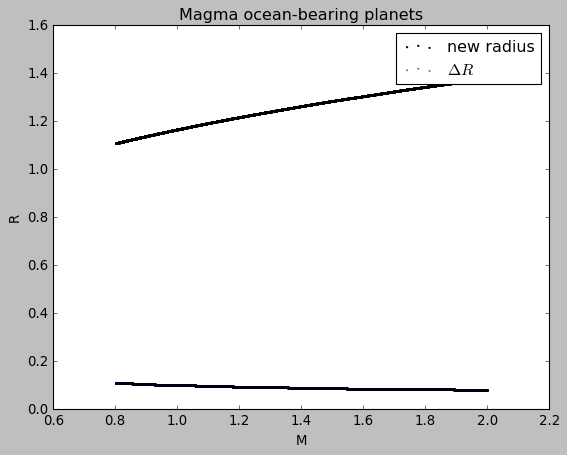

In [234]:
# check if M-R relation looks good:
d = sample.to_pandas()
mo = d[d.has_magmaocean]
plt.scatter(mo.M, mo.R, s=1., label='new radius')
plt.scatter(mo.M, mo.R - mo.R_orig, s=1., label='$\Delta R$', alpha=.4)
plt.xlabel('M')
plt.ylabel('R')
plt.title('Magma ocean-bearing planets')
plt.legend()

radius_change = np.average(mo.R/mo.R_orig) - 1
print('avg radius change of runaway GH planets: {:+.0f} %'.format(100*radius_change))
density_change = np.average(mo.rho/(CONST['rho_Earth']*mo.M/mo.R_orig**3)) - 1
print('avg density change of runaway GH planets: {:+.0f} %'.format(100*density_change))

N_transiting: 621


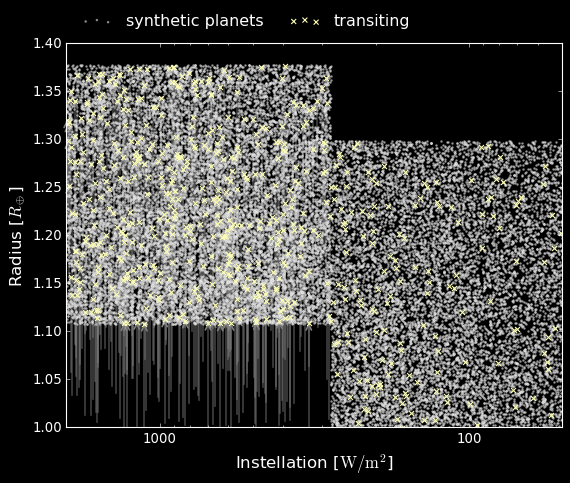

In [235]:
# show sample in period-radius:

from matplotlib.ticker import ScalarFormatter


talk = True
if talk:
    plt.style.use('dark_background')
else:
    plt.style.use('default')

yvar = parameter_of_interest

sampledf = sample.to_pandas()
# fig, ax = plt.subplots(figsize=[10, 6])
fig, ax = plt.subplots()
ax.scatter(sampledf[sampledf.transiting==False].S_abs, sampledf[sampledf.transiting==False][yvar], s=1.5, c='dimgray',alpha=.5, label='synthetic planets')

sampledf[sampledf.transiting==False].rho

# transiting planets
ax.scatter(sampledf[sampledf.transiting==True].S_abs, sampledf[sampledf.transiting==True][yvar], s=20,  marker='x', c='C1', label='transiting')

# show differences in radius due to magma ocean
if yvar =='R':
    X_coords= np.array([sampledf[sampledf.transiting==True].S_abs, sampledf[sampledf.transiting==True].S_abs])
    Y_coords=np.array([sampledf[sampledf.transiting==True].R_orig, sampledf[sampledf.transiting==True].R])
    ax.plot(X_coords, Y_coords, c='gray', lw=1.5, alpha=.5, zorder=-1)
    
    for i in range(len(sampledf[sampledf.transiting==True])):
        if Y_coords[1][i] != Y_coords[0][i]:
            ax.annotate(
              "",
              xy=(X_coords[0][i], Y_coords[1][i]), xytext=(0, -1.),#xytext=(0., Y_coords[1][i]),
              textcoords='offset points', ha='right', va='bottom',
              bbox=dict(boxstyle='round,pad=0.5',  alpha=0.5),
              arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0', alpha=.5, lw=1.5),
            zorder = -9
           )
    
    ax.set_ylabel('Radius [$R_\oplus$]',fontsize=15)
elif yvar == 'rho':
    ax.set_ylabel('bulk density [$\mathrm{g/cm^3}$]',fontsize=15)
     
# ax.text(.98, .9, 'water/rock = {:.0e}'.format(planets_args['wrr']), horizontalalignment='right', verticalalignment='bottom', transform=ax.transAxes)

# ax.set_xlabel('Solar-equivalent semimajor axis [au]')
ax.set_xlabel('Instellation [$\mathrm{W/m^2}$]',fontsize=15)
# ax.loglog()
ax.set_xscale('log')
ax.legend(loc='lower left', ncol=3, bbox_to_anchor=(0.0, 1.),
                              frameon=False, columnspacing=1.6)
plt.xlim(50., 2000.) 
plt.ylim(1., 1.4)

ax.invert_xaxis()
for axis in [ax.xaxis, ax.yaxis]:
    axis.set_major_formatter(ScalarFormatter())

print('N_transiting: {}'.format(len(sampledf[sampledf.transiting==True])))

In [236]:
# fig.savefig('/Users/schlecker/repos/magmaocean/src/tex/figures/synthetic_population.pdf', bbox_inches='tight')
# fig.savefig(talkfigdir + 'instellation-radius_N32.png', bbox_inches='tight', dpi=600)

Same plot with only transiting planets

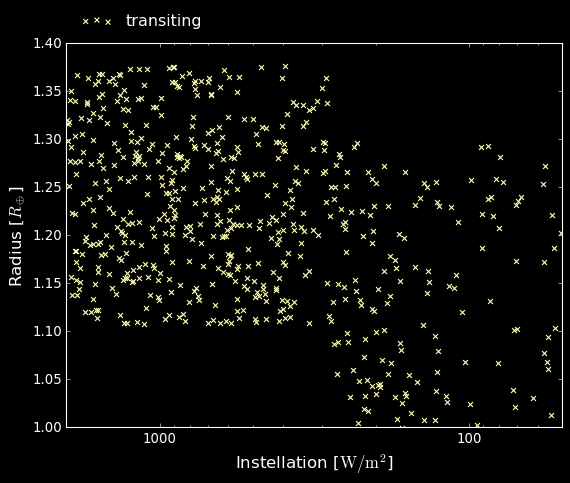

In [237]:
talk = True
if talk:
    plt.style.use('dark_background')

yvar = parameter_of_interest
sampledf = sample.to_pandas()

# fig, ax = plt.subplots(figsize=[10, 6])
fig, ax = plt.subplots()
ax.scatter(sampledf[sampledf.transiting==True].S_abs, sampledf[sampledf.transiting==True][yvar], s=20,  marker='x', c='C1', label='transiting')

if yvar =='R':
    ax.set_ylabel('Radius [$R_\oplus$]',fontsize=15)
elif yvar == 'rho':
    ax.set_ylabel('bulk density [$\mathrm{g/cm^3}$]',fontsize=15)
     
# ax.text(.98, .9, 'water/rock = {:.0e}'.format(planets_args['wrr']), horizontalalignment='right', verticalalignment='bottom', transform=ax.transAxes)

# ax.set_xlabel('Solar-equivalent semimajor axis [au]')
ax.set_xlabel('Instellation [$\mathrm{W/m^2}$]',fontsize=15)
# ax.loglog()
ax.set_xscale('log')
ax.legend(loc='lower left', ncol=3, bbox_to_anchor=(0.0, 1.),
                              frameon=False, columnspacing=1.6)
plt.xlim(50., 2000.) 
plt.ylim(1., 1.4)

ax.invert_xaxis()
for axis in [ax.xaxis, ax.yaxis]:
    axis.set_major_formatter(ScalarFormatter())

In [238]:
# fig.savefig(talkfigdir + 'instellation-radius_transiting.png', bbox_inches='tight', dpi=600)
# fig.savefig(talkfigdir + 'instellation-radius_N500.png', bbox_inches='tight', dpi=600)

## Explore radius-sma dependency
Let's have a look at the (effective) sma dependence of planets bearing magma oceans. Hypothesis tests are based on the average planet radius *outside* the threshold instellation S_thresh.

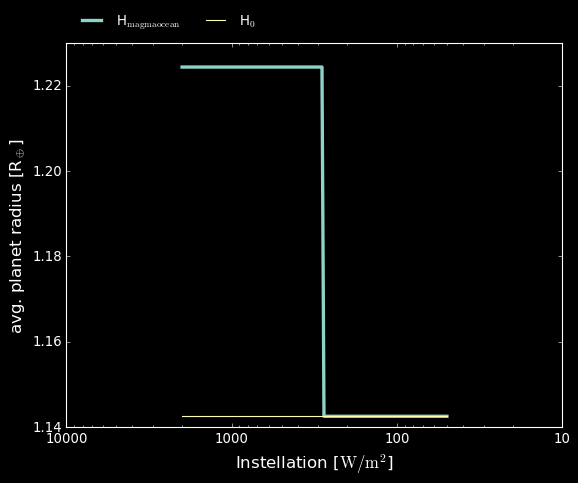

In [239]:
from bioverse.hypothesis import magma_ocean_hypo, magma_ocean_f0, get_avg_deltaR_deltaRho 
from bioverse.util import S2a_eff, a_eff2S
from matplotlib.ticker import ScalarFormatter
import scipy

talk = True
if talk:
    plt.style.use('dark_background')

def binned_stats(df, x_param, y_param, bins, statistic='mean'):
    means, edges, n = scipy.stats.binned_statistic(df[x_param], df[y_param], 
                                             statistic=statistic, bins=bins)
    std = []
    for e_lo, e_hi in zip(edges[:-1], edges[1:]):
        std.append(np.std(df[(df[x_param] > e_lo) & (df[x_param] < e_hi)][y_param]))
    return means, edges, n, std

# a_eff_grid = np.geomspace(0.05, 10., num=250)         # a_eff grid
S_grid = np.linspace(50., 2000., 250)
a_eff_grid = S2a_eff(S_grid)

R_avg_out = np.average(sample['R'][sample['S_abs'] < planets_args['S_thresh']])
R_avg_in = np.average(sample['R'][sample['S_abs'] >= planets_args['S_thresh']])

rho_avg_out = np.average(CONST['rho_Earth']*sample['M'][sample['S_abs'] < planets_args['S_thresh']]/
                         (sample['R'][sample['S_abs'] < planets_args['S_thresh']])**3)
rho_avg_in = np.average(CONST['rho_Earth']*sample['M'][sample['S_abs'] >= planets_args['S_thresh']]/
                         (sample['R'][sample['S_abs'] >= planets_args['S_thresh']])**3)

# P_magma = magma_ocean_hypo_step((planets_args['f_magma'], planets_args['a_cut'], 
                                 # planets_args['radius_reduction'], R_avg), a_eff_grid)
# P_magma = magma_ocean_hypo_exp((planets_args['f_magma'], planets_args['a_cut'], 
                                 # planets_args['lambda_a']), a_eff_grid)
    
avg_deltaR_deltaRho = get_avg_deltaR_deltaRho() # import avg_deltaR_deltaRho once here to avoid a lot of file I/O during hypothesis calls
if parameter_of_interest == 'R':
    P_magma = magma_ocean_hypo((planets_args['S_thresh'], planets_args['wrr'], R_avg_out), a_eff_grid, 
                               gh_increase=planets_args['gh_increase'], water_incorp=planets_args['water_incorp'],
                               simplified=planets_args['simplified'], diff_frac=radius_change,
                               parameter_of_interest=parameter_of_interest, avg_deltaR_deltaRho=avg_deltaR_deltaRho)
    
    
    P0 = magma_ocean_f0(R_avg_out, a_eff_grid)
elif parameter_of_interest == 'rho':
    P_magma = magma_ocean_hypo((planets_args['S_thresh'], planets_args['wrr'], rho_avg_out), a_eff_grid, diff_frac=density_change,
                               parameter_of_interest=parameter_of_interest, avg_deltaR_deltaRho=avg_deltaR_deltaRho)
    P0 = magma_ocean_f0(rho_avg_out, a_eff_grid)

# backtransform from a_eff to S
S_grid = a_eff2S(a_eff_grid)

plt.plot(S_grid, P_magma, label='H$_\mathrm{magma ocean}$', lw=3)
plt.plot(S_grid, P0, label='H$_0$')
plt.xscale('log')

# plt.xlabel('Solar-equivalent semimajor axis [au]',fontsize=15)
plt.xlabel('Instellation [$\mathrm{W/m^2}$]',fontsize=15)

if parameter_of_interest == 'R':
    if talk:
        plt.ylabel('avg. planet radius [R$_\oplus$]',fontsize=15)
    else:
        plt.ylabel('$<R_P>$',fontsize=15)
elif parameter_of_interest == 'rho':
    plt.ylabel('$<\\rho>$',fontsize=15)

fig = plt.gcf()
ax = plt.gca()
ax.invert_xaxis()
for axis in [ax.xaxis, ax.yaxis]:
    axis.set_major_formatter(ScalarFormatter())
    
# plt.ylim(1., 1.4)


# sanity check to see if the function that assigns magma oceans is consistent with the hypothesis:
# a_eff_griddf = pd.DataFrame([a_eff_grid,[R_avg for i in range(len(a_eff_grid))]], index=['a_eff', 'R']).T
# Y = magma_ocean(a_eff_griddf, funform='step', f_magma=planets_args['f_magma'], a_cut=planets_args['a_cut'], radius_reduction=planets_args['radius_reduction'])
# plt.scatter(a_eff_griddf.S_abs, Y.R, label='planets', s=2, c='k')

# plot binned stats as errorbar plot
# means, edges, n, std = binned_stats(Y, 'S_abs', 'R', np.geomspace(np.min(Y['S_abs']), 2*np.max(Y['S_abs']), num=10))
# # ax.hlines(np.mean(Y['R']), np.min(Y['S_abs']), np.max(Y['S_abs']), color='C2', label='mean $R_P$')
# plt.errorbar(edges[:-1]+(edges[1:]-edges[:-1])/2, means, xerr=(edges[1:]-edges[:-1])/2,
#            yerr=None, fmt='none', color='C6', label='binned $R_P$ statistic', elinewidth=2.5)


plt.legend(fontsize=12, loc='lower left', ncol=3, bbox_to_anchor=(0.0, 1.),
                              frameon=False, columnspacing=1.6)

In [240]:
# fig.savefig(talkfigdir + 'HnullHmo.png', bbox_inches='tight', dpi=600)

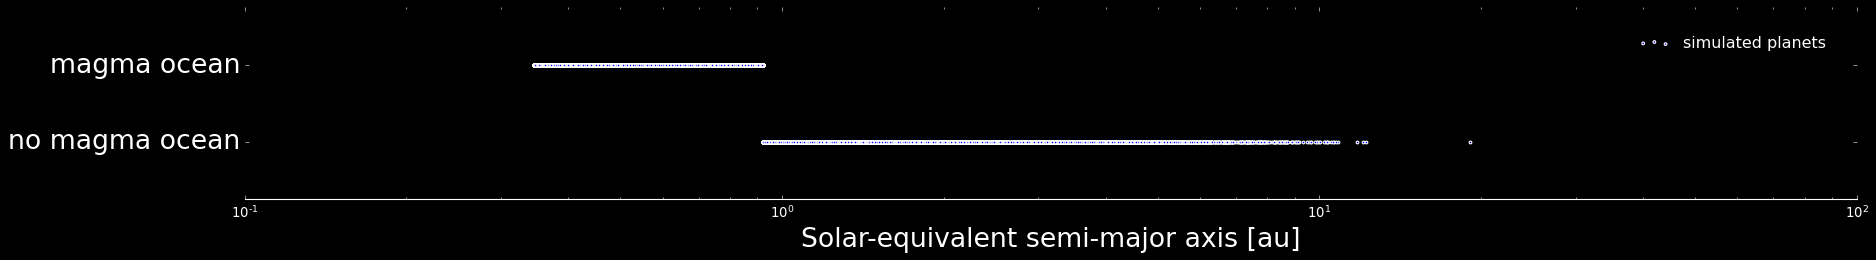

In [241]:
x, y = sample['a_eff'], sample['has_magmaocean']

# Now plot the water-rich/water-poor planets versus a_eff (in log-space)
fig, ax = plt.subplots(figsize=(26,3))
ax.scatter(x,y, s=6, label='simulated planets')
ax.set_xscale('log')
ax.set_yticks([0,1])
ax.set_yticklabels(['no magma ocean','magma ocean'],fontsize=24)
ax.set_xlabel('Solar-equivalent semi-major axis [au]',fontsize=24)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
# To turn off the bottom or left
#ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.set_ylim(-.75, 1.75)
ax.legend(loc='lower right', ncol=99, bbox_to_anchor=(.99, .7),
                              frameon=False, columnspacing=1.6)
plt.show()

In [242]:
# fig.savefig('/Users/schlecker/repos/magmaocean/src/tex/figures/has_magmaocean.pdf', bbox_inches='tight')

plot Phi(k) correlation between planets having a magma ocean and planets smaller than the mean of the populatio

In [243]:
# import phik
# from phik import resources, report

# sample.to_pandas()[['is_small', 'has_magmaocean']].hist2d()
# sample.to_pandas()[['is_small', 'has_magmaocean']].phik_matrix()

# Compute radius differences to inform hypotheses

The magma ocean hypotheses rely on measurements of average radii and bulk densities. Here, we create a table to inform the hypothesis function.


-------
**This needs to be executed whenever:**
- file `avg_deltaR_deltaRho.csv` is not available
- stars or planets are generated from a different source (e.g. different occurrence rates)
- new biases/sample limits are introduced (e.g. minimum planet radius, transit depth, ...)

-------

In [244]:
# %%time

# wrr_grid = [0.0001, 0.001, 0.005, 0.01, 0.02, 0.03, 0.04, 0.05]
# # wrr_grid = [0.001]

# avg_deltaR_deltaRho = []

# def zero_change(avg_deltaR_deltaRho, gh_increase, water_incorp, wrr):
#     avg_deltaR_deltaRho.append({
#             'gh_increase': gh_increase,
#             'water_incorp': water_incorp,
#             'wrr': wrr,
#             'delta_R': 0.,
#             'delta_rho': 0. 
#             })
#     return(avg_deltaR_deltaRho)

# for gh_increase in [False, True]:
#     for water_incorp in [False, True]:
#         # wrr=0 case:
#         avg_deltaR_deltaRho = zero_change(avg_deltaR_deltaRho, gh_increase, water_incorp, wrr=0.)
#         if gh_increase or water_incorp:
#             for wrr in wrr_grid:
#                 planets_args['wrr'] = wrr 
#                 g_transit = Generator(label=None)
#                 g_transit.insert_step('read_stars_Gaia')
#                 g_transit.insert_step('create_planets_bergsten')
#                 g_transit.insert_step('assign_orbital_elements')
#                 g_transit.insert_step('impact_parameter')
#                 g_transit.insert_step('assign_mass')
#                 g_transit.insert_step('effective_values')
#                 g_transit.insert_step('magma_ocean')
#                 g_transit.insert_step('compute_transit_params')
#                 [g_transit.set_arg(key, val) for key, val in stars_args.items()]
#                 [g_transit.set_arg(key, val) for key, val in planets_args.items()]
                
#                 # set MO mechanisms according to current iteration
#                 g_transit.set_arg('gh_increase', gh_increase)
#                 g_transit.set_arg('water_incorp', water_incorp)
                
#                 # generate stars and planets
#                 planets = g_transit.generate()

#                 # apply the exact same sample selections as in the actual analysis
#                 planets = planets[planets.to_pandas()['M'].between(0.1, 2.).values]
#                 planets = planets[planets['R'] > .75]
#                 planets = planets[planets['S_abs'] < 2000.]

#                 d = planets.to_pandas()
#                 mo = d[d.has_magmaocean]

#                 avg_deltaR_deltaRho.append({
#                         'gh_increase': gh_increase,
#                         'water_incorp': water_incorp,
#                         'wrr': wrr,
#                         'delta_R': np.average(mo.R/mo.R_orig) - 1,
#                         'delta_rho': np.average(mo.rho/(CONST['rho_Earth']*mo.M/mo.R_orig**3)) - 1
#                         })
#         else:
#             # if none of the mechanisms active: zero change.
#             for wrr in wrr_grid:
#                 avg_deltaR_deltaRho = zero_change(avg_deltaR_deltaRho, gh_increase, water_incorp, wrr)
    
# avg_deltaR_deltaRho = pd.DataFrame(avg_deltaR_deltaRho)

# # write table to file
# with open(DATA_DIR + 'avg_deltaR_deltaRho.csv', 'w') as f:
#     f.write('# Radius and bulk density differences based on a sample of ' 
#     'low-mass (0.1-2 Mearth) and detectable (>0.75 Rearth) planets, '
#     'excluding extreme irradiances (>2000 W/m2).\n')
#     avg_deltaR_deltaRho.to_csv(f, index=False)

# Survey simulation

We have generated a population of synthetic planets that orbit synthetic stars and we have injected a statistical trend originating from the presence of magma oceans on some planets. Only a subset of these planets "will be detectable by a transit or direct imaging survey. For those planets, only a subset of their properties can be directly probed, and only with a finite level of precision."

In the following, we will simulate a transit survey and try to detect the (population-wide) effect on the planet radius caused by global magma oceans

## Define transit survey

let's define some key parameters of the survey: [TODO: check which ones are needed to define our transit surveys]
- ``diameter``: the diameter of the telescope primary in meters (or the area-equivalent diameter for a telescope array)
- ``t_max``: maximum amount of time across which to combine transit observations, in days
- ``N_obs_max``: maximum allowable number of transit observations per target
- ``t_slew``: slew time between observations, in days
- ``D_ref``: diameter of the reference telescope, in meters

e.g., we could choose values similar to the ones expected for the LIFE telescope array (LIFE collaboration, 2021). In the nominal configuration with four 2 m telescopes, it would have a equivalent light-collecting area of a 4 m telescope.

In [245]:
survey = TransitSurvey(diameter=8.5, t_max=3652.5, t_slew=0.1, N_obs_max=1000)
# survey = TransitSurvey(diameter=.5, t_max=3.6525, t_slew=0.1, N_obs_max=2)

Created a new TransitSurvey


Let's add some measurements our survey conducts. 'small_radius' is True for a planet if it has a radius smaller than the mean of the population.

In [246]:
margs = {}
mkeys = ['L_st', 'R_st', 'M_st', 'T_eff_st', 'd', 'age', 'depth', 'R', 'T_dur', 
         'P', 'a', 'a_eff', 'S', 'S_abs',
         'M', 'rho']

# GOOD survey: choose super-optimistic values for now.
margs['precision'] = {'T_eff_st': 25.,
                      'R_st': '1%',
                      'depth': '1%',
                      'R': '1%',
                      'M_st': '1%',
                      'age': '30%',
                      'P': 0.000001,
                      'S': '1%',
                      'M': '5%',
                      'rho': '7%'}


# # BAD survey: choose rather modest survey performance.
# margs['precision'] = {'T_eff_st': 75.,
#                       'R_st': '20%',
#                       'depth': '20%',
#                       'R': '20%',
#                       'M_st': '30%',
#                       'age': '75%',
#                       'P': 0.01,
#                       'S': '20%',
                      # 'M': '5%',
                      # 'rho': '7%'}




# Add the measurements to s_transit
for mkey in mkeys:
    kwargs = {}
    for key, vals in margs.items():
        if mkey in vals:
            kwargs[key] = vals[mkey]
    survey.add_measurement(mkey, **kwargs)
# survey

which planets are detectable?

In [247]:
detected = survey.compute_yield(sample)
N = len(detected)
print(N)

621


simulate observations, obtain dataset

In [248]:
data = survey.observe(detected)
data.to_pandas().head()


,planetID,starID,L_st,R_st,M_st,T_eff_st,d,age,depth,R,T_dur,P,a,a_eff,S,S_abs,M,rho
0,150,191,0.00442,0.215513,0.183183,3226.924497,9.730,1.620214,0.002605,1.208703,0.052239,5.326631,0.033889,0.509746,3.846787,915.945278,1.158737,3.429262
1,1418,1816,0.08111,0.646756,0.631589,4031.159270,20.403,8.188671,0.000368,1.361218,0.137733,14.523972,0.099926,0.350867,8.136205,1933.270071,1.853029,4.432293
2,2734,3463,0.02257,0.422020,0.412581,3502.694920,25.070,9.899032,0.000859,1.332143,0.086985,8.039539,0.058443,0.389015,6.564219,1572.690973,1.634904,4.131548
3,3684,4660,0.01274,0.337155,0.315771,3373.981379,27.590,4.713268,0.001053,1.202366,0.051891,10.572287,0.064280,0.569500,3.122008,733.820145,1.107193,3.509504
4,3802,4816,0.01157,0.335124,0.312657,3231.084194,27.910,3.010029,0.000798,1.047545,0.089570,26.239772,0.118082,1.097782,0.823158,197.489665,0.955331,3.964646


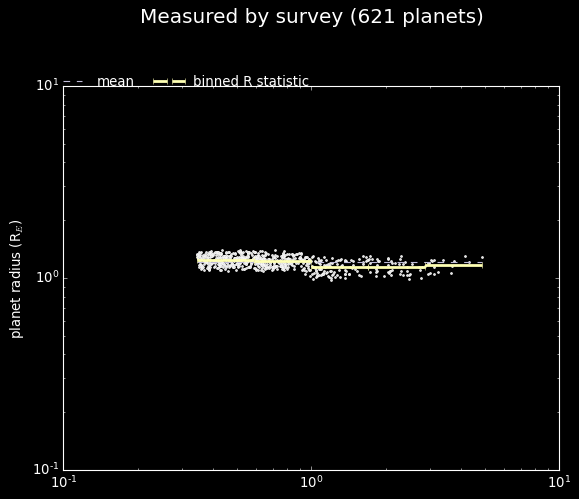

In [249]:
yvar = parameter_of_interest
xvar = 'a_eff'
yvar = 'R' 

fig, ax = plt.subplots()
ax.scatter(data[xvar], data[yvar], s=2, c='k')
ax.set_xscale('log')
ax.set_yscale('log')



# plot binned stats as errorbar plot
means, edges, n, std = binned_stats(data, xvar, yvar, np.geomspace(np.min(data[xvar]), np.max(data[xvar]), num=6), statistic='mean')
ax.hlines(np.mean(data[yvar]), np.min(data[xvar]), np.max(data[xvar]), color='C2', ls='--', label='mean')
ax.errorbar(edges[:-1]+(edges[1:]-edges[:-1])/2, means, xerr=(edges[1:]-edges[:-1])/2,
           yerr=None, fmt='none', color='C1', label='binned {} statistic'.format(yvar), elinewidth=2.5)

if xvar == 'S_abs':
    ax.set_xlabel('Instellation [W/m2]')
    ax.axvline(planets_args['S_thresh'], ls='-.', c='gray', alpha=.33)
    ax.invert_xaxis()

if yvar == 'R':
    ax.set_ylabel('planet radius (R$_E$)')
elif yvar == 'rho':
    ax.set_ylabel('bulk density(g/cm3)')
    
ax.set_title('Measured by survey ({} planets)'.format(N), y=1.15, fontsize=18)
fig.legend(fontsize=12, loc='lower left', ncol=99, bbox_to_anchor=(0.1, .87),
                              frameon=False, columnspacing=1.6)


# Hypothesis tests 

## Define Hypotheses
These assume a specific functional form

In [250]:
from bioverse.hypothesis import Hypothesis, magma_ocean_hypo, magma_ocean_f0, get_avg_deltaR_deltaRho 

# params = ('f_magma', 'a_cut', 'radius_reduction', 'R_avg')    # for step function
# params = ('f_magma', 'a_cut', 'lambda_a')   # for exp. decay
if parameter_of_interest == 'R':
    params = ('S_thresh', 'wrr', 'avg')
    labels = ('R',)
elif parameter_of_interest == 'rho':
    params = ('S_thresh', 'wrr', 'avg')
    labels = ('rho',)
features = ('a_eff',)

# define priors for the parameters in theta (log-uniform for 'S_thresh' and 'wrr', uniform for 'R_avg')
bounds = np.array([[10., 1000.0], [1e-5, 0.10], [.1, 15.]])
log = (True, True, False)
# bounds = np.array([[0.001, 1.0], [0.01, 10.], [0.005, 4.]]) # for exp decay
# log = (False, True, False) # for exp decay

# 

avg_deltaR_deltaRho = get_avg_deltaR_deltaRho() # import avg_deltaR_deltaRho once here to avoid a lot of file I/O during hypothesis calls

# define hypothesis; define null hypothesis (a broad distribution in planet radius that is independent of orbital distance)
bounds_null = np.array([[0.01, 100.]]) # prior bounds for null hypothesis
if parameter_of_interest == 'R':
    h_magmaocean = Hypothesis(magma_ocean_hypo, bounds, params=params, features=features, labels=labels, 
                              log=log, gh_increase=planets_args['gh_increase'], water_incorp=planets_args['water_incorp'], 
                              simplified=planets_args['simplified'], diff_frac=radius_change, parameter_of_interest=parameter_of_interest, avg_deltaR_deltaRho=avg_deltaR_deltaRho)
    h_magmaocean.h_null = Hypothesis(magma_ocean_f0, bounds_null, params=('R_avg_random',), features=features, labels=labels, log=(True,))
elif parameter_of_interest == 'rho':
    h_magmaocean = Hypothesis(magma_ocean_hypo, bounds, params=params, features=features, labels=labels, 
                              log=log, gh_increase=planets_args['gh_increase'], water_incorp=planets_args['water_incorp'],
                              simplified=planets_args['simplified'], diff_frac=density_change, parameter_of_interest=parameter_of_interest, avg_deltaR_deltaRho=avg_deltaR_deltaRho)
    # h_magmaocean = Hypothesis(magma_ocean_hypo_exp, bounds, params=params, features=features, labels=labels, log=log)
    h_magmaocean.h_null = Hypothesis(magma_ocean_f0, bounds_null, params=('rho_avg_random',), features=features, labels=labels, log=(True,))

## Perform hypothesis testing 

Sample posterior; Calculate the Bayesian evidence supporting h_magmaocean in favor of h_null from our simulated dataset.

The parameter space is complex, need to use nested sampling (not MCMC).

In [251]:
%%time
import corner

# Sample the posterior distribution of h(theta | x, y) using a simulated data set, and compare to the null hypothesis via a model comparison metric.
results = h_magmaocean.fit(data, return_chains=True, nburn=100, nlive=200)
 
print("The evidence in favor of the hypothesis is: dlnZ = {:.1f} (corresponds to p = {:.3f})".format(
    results['dlnZ'], np.exp(-results['dlnZ'])))

The evidence in favor of the hypothesis is: dlnZ = 4289.9 (corresponds to p = 0.000)
CPU times: user 41.3 s, sys: 262 ms, total: 41.5 s
Wall time: 41.8 s


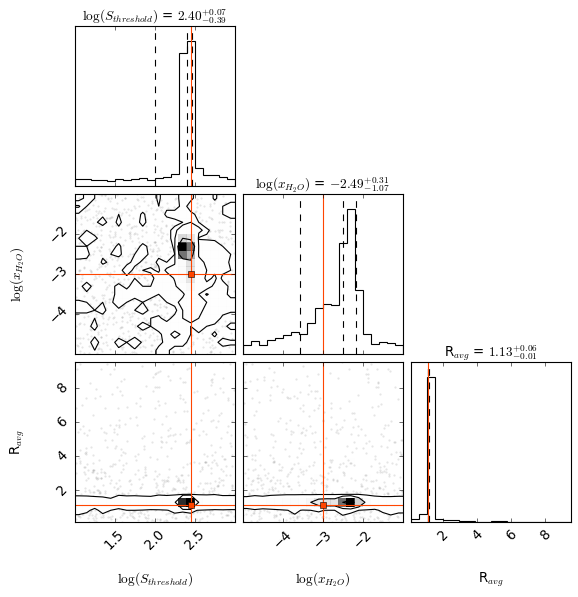

In [252]:
plt.style.use('classic')

# turn into DataFrame, make logged columns for params with log priors
chains = pd.DataFrame(results['chains'], columns=params)
for p, l in zip(params, log):
    if l:
        chains['log_' + p] = np.log10(chains[p])

fig = corner.corner(
                    # chains[['f_magma', 'log_a_cut', 'radius_reduction']], labels=['$\eta_{magma}$', '$\log(a_{cut})$','$f_{R_\mathrm{P}}$'],
                    # chains[['f_magma', 'log_a_cut', 'lambda_a']], labels=['$\eta_{magma}$', '$\log(a_{cut})$','$\lambda_a$'],
                    # chains[['f_magma', 'log_a_cut', 'radius_reduction','R_avg']], labels=['$\eta_{magma}$', '$\log(a_{cut})$','$f_{R_\mathrm{P}}$', 'R$_{avg}$'],
                    chains[['log_S_thresh', 'log_wrr', 'avg']], labels=['$\log(S_{threshold})$', '$\log(x_{H_2O})$', 'R$_{avg}$'],
                    quantiles=[0.16, 0.5, 0.84],
                    show_titles=True, title_kwargs={"fontsize": 12},
                    truths=[np.log10(planets_args['S_thresh']), np.log10(planets_args['wrr']), R_avg_out], truth_color='orangered'
                    # truths=[planets_args['f_magma'], np.log10(planets_args['a_cut']), planets_args['lambda_a']], truth_color='orangered'
                    # truths=[planets_args['f_magma'], np.log10(planets_args['a_cut']), planets_args['radius_reduction'], R_avg], truth_color='orangered'
                    )

fig.set_facecolor('white')

$S_{threshold}$ is recovered for large enough samples (>~1000, with only Turbe+2020 mechanism, and with high enough water fraction). Weird: when it's not recovered, there is a very sharp peak elsewhere.

# Statistical Power
Test sensitivity on Poisson uncertainty, e.g. the specific realization of a survey.

In [ ]:
%%time

from bioverse import analysis

# Repeat the hypothesis test for different magma ocean parameter values
# S_thresh_grid = np.linspace(10, 1500, 6)
# wrr_grid = [0.0001,0.001, 0.005, 0.01, 0.02, 0.03, 0.04, 0.05]
# wrr_grid = [0., 0.0001, 0.01, 0.05]
d_grid = np.round(np.geomspace(15, 60, 8))

# results = analysis.test_hypothesis_grid(h_magmaocean, g_transit, survey, S_thresh=S_thresh_grid, N=10, processes=8)
# results = analysis.test_hypothesis_grid(h_magmaocean, g_transit, survey, wrr=wrr_grid, N=10, processes=8)
results = analysis.test_hypothesis_grid(h_magmaocean, g_transit, survey, d_max=d_grid, N=20, processes=8, **planets_args)

# Determine the statistical power assuming a significance threshold of dlnZ > 3
# power = analysis.compute_statistical_power(results, method='dlnZ', threshold=3)
# print("The statistical power of the survey is {:.1f}%".format(100*power))

 48%|███████████████████████████████████████████▏                                               | 76/160 [03:53<03:36,  2.58s/it]

In [ ]:
# plt.plot(S_thresh_grid, results['dlnZ'].mean(axis=-1), lw=5)
# plt.plot(wrr_grid, results['dlnZ'].mean(axis=-1), lw=5)
# plt.plot(d_grid, results['dlnZ'].mean(axis=-1), lw=5)
plt.plot(results['N_pl'][:,0], results['dlnZ'].mean(axis=-1), lw=3)

percentiles = np.percentile(results['dlnZ'], [5., 95.], axis=1)    # 5% and 95% percentiles

lns2 = plt.fill_between(results['N_pl'][:,0],
                     percentiles[0],
                     percentiles[1],
                     color=(0.45, 0.65, 0.9), alpha=.5,
                     label="90\% prediction interval")

# plt.xlabel('S_thresh', fontsize=20)
# plt.xlabel('water fraction', fontsize=20)
# plt.xlabel('d_max', fontsize=20)
plt.xlabel('Planet yield $N_\mathrm{detections}$', fontsize=20)

plt.ylabel('$\Delta$lnZ', fontsize=20)
plt.axhline(3, lw=5, c='black', linestyle='dashed')
plt.xscale('log')
# plt.yscale('log')
# plt.xlim(right=500)


# plt.loglog()
